<a href="https://colab.research.google.com/github/SarahSouzaPontes/previsaoIPCA/blob/main/Previs%C3%A3o_IPCA_Redes_Neurais(Sarah_Pontes).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Instalando bibliotecas
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import seaborn as sns
import plotly.express as px
!pip install dash -q
import dash
from dash import Dash, dcc, html, Input, Output
import requests
import json
import re
from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from math import sqrt
from matplotlib import pyplot

     |████████████████████████████████| 9.8 MB 28.5 MB/s 
     |████████████████████████████████| 357 kB 60.8 MB/s 


In [ ]:
#Json da API IPCA
url_ipca = "https://servicodados.ibge.gov.br/api/v3/agregados/118/periodos/199801|199802|199803|199804|199805|199806|199807|199808|199809|199810|199811|199812|199901|199902|199903|199904|199905|199906|199907|199908|199909|199910|199911|199912|200001|200002|200003|200004|200005|200006|200007|200008|200009|200010|200011|200012|200101|200102|200103|200104|200105|200106|200107|200108|200109|200110|200111|200112|200201|200202|200203|200204|200205|200206|200207|200208|200209|200210|200211|200212|200301|200302|200303|200304|200305|200306|200307|200308|200309|200310|200311|200312|200401|200402|200403|200404|200405|200406|200407|200408|200409|200410|200411|200412|200501|200502|200503|200504|200505|200506|200507|200508|200509|200510|200511|200512|200601|200602|200603|200604|200605|200606|200607|200608|200609|200610|200611|200612|200701|200702|200703|200704|200705|200706|200707|200708|200709|200710|200711|200712|200801|200802|200803|200804|200805|200806|200807|200808|200809|200810|200811|200812|200901|200902|200903|200904|200905|200906|200907|200908|200909|200910|200911|200912|201001|201002|201003|201004|201005|201006|201007|201008|201009|201010|201011|201012|201101|201102|201103|201104|201105|201106|201107|201108|201109|201110|201111|201112|201201|201202|201203|201204|201205|201206|201207|201208|201209|201210|201211|201212|201301|201302|201303|201304|201305|201306|201307|201308|201309|201310|201311|201312|201401|201402|201403|201404|201405|201406|201407|201408|201409|201410|201411|201412|201501|201502|201503|201504|201505|201506|201507|201508|201509|201510|201511|201512|201601|201602|201603|201604|201605|201606|201607|201608|201609|201610|201611|201612|201701|201702|201703|201704|201705|201706|201707|201708|201709|201710|201711|201712|201801|201802|201803|201804|201805|201806|201807|201808|201809|201810|201811|201812|201901|201902|201903|201904|201905|201906|201907|201908|201909|201910|201911|201912|202001|202002|202003|202004|202005|202006|202007|202008|202009|202010|202011|202012|202101|202102|202103|202104|202105|202106|202107|202108|202109|202110|202111|202112|202201|202202|202203|202204|202205|202206|202207|202208|202209/variaveis/306?localidades=N1[all]"

ipca_raw = requests.get(url_ipca)
if(ipca_raw.status_code != 200):
  print("url inválida.")
else:
  ipca = ipca_raw.json()
  

In [ ]:
#Preparação dos dados
titulo = ipca[0]["variavel"]
unidade = ipca[0]["unidade"]
serie = ipca[0]["resultados"][0]["series"][0]["serie"]

for i in serie:
  serie[i]=float(serie[i])
serie= {"ANO":pd.Series(serie.keys()), "IPCA":pd.Series(serie.values())}
serie = pd.DataFrame(serie)
serie["ANO"] = pd.to_datetime(serie.ANO, format='%Y%m')

In [ ]:
#Análise gráfica
IPCA_plot = px.data.gapminder()
fig = px.line(serie, x=serie.index, y='IPCA_OUTPUT', title=titulo)
fig.show()

In [ ]:
#Transformando data para index
serie.set_index("ANO", inplace =True)

In [ ]:
#Visualizando Histograma para verificar a distribuição dos dados
serie.hist()

In [ ]:
result = adfuller(serie.IPCA)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

In [ ]:
lag =1
columns = [serie.shift(i) for i in range(1, lag+1)]
columns.append(serie)
serie = pd.concat(columns, axis=1)
serie.fillna(0, inplace=True)

In [ ]:
serie.columns.values[0]="IPCA_INPUT"
serie.columns.values[1]="IPCA_OUTPUT"

In [ ]:
#Informações do Dataset
serie.info()

In [ ]:
#Visulizando primeiras linhas
serie

,IPCA_INPUT,IPCA_OUTPUT
ANO,,
1998-01-01,0.00,0.59
1998-02-01,0.59,0.44
1998-03-01,0.44,0.28
1998-04-01,0.28,0.17
1998-05-01,0.17,0.48
...,...,...
2022-05-01,1.03,0.52
2022-06-01,0.52,0.73
2022-07-01,0.73,-0.61


In [ ]:
#IPCA input / output
serie.plot(figsize=(20,6))

In [ ]:
def scale(train, test):
  # Escalar
  scaler = MinMaxScaler(feature_range=(-1, 1))
  scaler = scaler.fit(train)
	# train
  train = train.reshape(train.shape[0], train.shape[1])
  train_scaled = scaler.transform(train)
	# test
  test = test.reshape(test.shape[0], test.shape[1])
  test_scaled = scaler.transform(test)
  return scaler, train_scaled, test_scaled

def invert_scale(scaler, X, value):
	new_row = [x for x in X] + [value]
	array = np.array(new_row)
	array = array.reshape(1, len(array))
	inverted = scaler.inverse_transform(array)
	return inverted[0, -1]

def fit_lstm(train, batch_size, nb_epoch, neurons):
  X, y = train[:, 0:-1], train[:, -1]
  X = X.reshape(X.shape[0], 1, X.shape[1])
  model = Sequential()
  model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
  model.add(Dense(12, activation='tanh'))
  model.add(Dense(6, activation='tanh'))
  model.add(Dense(3, activation='tanh'))
  model.add(Dense(1))
  model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])
  estop = EarlyStopping(monitor='loss', mode='min', verbose=1, patience=20)
  mcheck = ModelCheckpoint('best_model.h5', monitor='loss', mode='min', verbose=1, save_best_only=True)

  for i in range(nb_epoch):
    model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False, callbacks=[estop, mcheck])
    model.reset_states()
  return model

def forecast_lstm(model, batch_size, X):
	X = X.reshape(1, 1, len(X))
	yhat = model.predict(X, batch_size=batch_size)
	return yhat[0,0]



In [ ]:
#Dividindo em dados de treino e teste
raw_values = serie['IPCA_OUTPUT'].values
supervised = serie.values[:-1]
train, test = supervised[0:-24], supervised[-24:]
scaler, train_scaled, test_scaled = scale(train, test)

In [ ]:
lstm_model = fit_lstm(train_scaled, 1, 100, 1)
# forecast 
train_reshaped = train_scaled[:, 0].reshape(len(train_scaled), 1, 1)
lstm_model.predict(train_reshaped, batch_size=1)



Epoch 1: loss improved from inf to 0.07507, saving model to best_model.h5

Epoch 1: loss improved from 0.07507 to 0.04789, saving model to best_model.h5

Epoch 1: loss improved from 0.04789 to 0.04501, saving model to best_model.h5

Epoch 1: loss improved from 0.04501 to 0.04278, saving model to best_model.h5

Epoch 1: loss improved from 0.04278 to 0.04122, saving model to best_model.h5

Epoch 1: loss improved from 0.04122 to 0.04016, saving model to best_model.h5

Epoch 1: loss improved from 0.04016 to 0.03940, saving model to best_model.h5

Epoch 1: loss improved from 0.03940 to 0.03882, saving model to best_model.h5

Epoch 1: loss improved from 0.03882 to 0.03835, saving model to best_model.h5

Epoch 1: loss improved from 0.03835 to 0.03794, saving model to best_model.h5

Epoch 1: loss improved from 0.03794 to 0.03758, saving model to best_model.h5

Epoch 1: loss improved from 0.03758 to 0.03725, saving model to best_model.h5

Epoch 1: loss improved from 0.03725 to 0.03694, saving 

array([[-0.7127479 ],
       [-0.47766107],
       [-0.6203653 ],
       [-0.627119  ],
       [-0.6568175 ],
       [-0.5688223 ],
       [-0.6915095 ],
       [-0.68242174],
       [-0.73574346],
       [-0.69983596],
       [-0.67599136],
       [-0.70220983],
       [-0.60628456],
       [-0.5546909 ],
       [-0.36184686],
       [-0.39754042],
       [-0.6025947 ],
       [-0.6229382 ],
       [-0.64573485],
       [-0.25244704],
       [-0.5810228 ],
       [-0.6080495 ],
       [-0.24266937],
       [-0.4624552 ],
       [-0.5678362 ],
       [-0.5665876 ],
       [-0.6761155 ],
       [-0.6396373 ],
       [-0.6012086 ],
       [-0.683335  ],
       [-0.6102305 ],
       [-0.01193288],
       [-0.2597306 ],
       [-0.66647965],
       [-0.63657254],
       [-0.6196489 ],
       [-0.5528255 ],
       [-0.59292996],
       [-0.59591854],
       [-0.61924124],
       [-0.5499132 ],
       [-0.60502946],
       [-0.5404395 ],
       [-0.16261858],
       [-0.55634314],
       [-0

1/1 [==============================] - 0s 16ms/step
Index=1, Predicted=0.253638, Expected=0.850000
1/1 [==============================] - 0s 14ms/step
Index=2, Predicted=0.472241, Expected=0.840000
1/1 [==============================] - 0s 13ms/step
Index=3, Predicted=0.525487, Expected=1.270000
1/1 [==============================] - 0s 15ms/step
Index=4, Predicted=0.515126, Expected=0.180000
1/1 [==============================] - 0s 15ms/step
Index=5, Predicted=0.909152, Expected=0.880000
1/1 [==============================] - 0s 17ms/step
Index=6, Predicted=0.151818, Expected=0.890000
1/1 [==============================] - 0s 13ms/step
Index=7, Predicted=0.703909, Expected=0.300000
1/1 [==============================] - 0s 14ms/step
Index=8, Predicted=0.505180, Expected=0.880000
1/1 [==============================] - 0s 15ms/step
Index=9, Predicted=0.224492, Expected=0.590000
1/1 [==============================] - 0s 15ms/step
Index=10, Predicted=0.644984, Expected=1.020000
1/1 [====

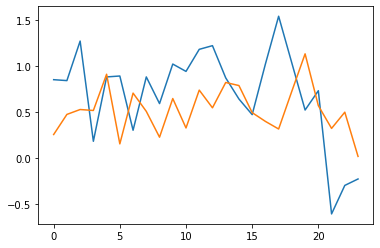

In [ ]:

predictions = list()
for i in range(len(test_scaled)):
	# make one-step forecast
	X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
	yhat = forecast_lstm(lstm_model, 1, X)
	# invert scaling
	yhat = invert_scale(scaler, X, yhat)
	# store forecast
	predictions.append(yhat)
	expected = raw_values[len(train) + i +1]
	print('Index=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
 
rmse = sqrt(mean_squared_error(raw_values[-24:], predictions))
print('Test RMSE: %.3f' % rmse)
# line plot of observed vs predicted

pyplot.plot(raw_values[-24:])
pyplot.plot(predictions)
pyplot.show()

In [ ]:
serie

,IPCA_INPUT,IPCA_OUTPUT
ANO,,
1998-01-01,0.00,0.59
1998-02-01,0.59,0.44
1998-03-01,0.44,0.28
1998-04-01,0.28,0.17
1998-05-01,0.17,0.48
...,...,...
2022-05-01,1.03,0.52
2022-06-01,0.52,0.73
2022-07-01,0.73,-0.61


In [ ]:
'''
        Aplicação de Redes Neurais foi a escolha após análise de outros modelos como o ARIMA. A ocorrência de relações entre os mais variados indicadores macroeconômicos repercutindo na elevação dos preços; este aspecto demonstra a complexidade
da modelagem deste problema. Cogitado previamente utilizar a API dos dados referentes a SELIC, mas sendo essa uma "resposta" ao IPCA seria necessário ajustar o lag, bem como assumir a possibilidade do não ajuste desses dados por questões políticas e econômicas, assim a previsão ficaria prejudicada. (ZANIOL et al. 2021)
    '''
    #Zaniol, C., Pazinatto, C. B. and Moraes, J. C. (2021).Intervalos de confiança de núcleos de inflação utilizando wavelets e redes neurais, Anais do X Encontro Regional de Matemática Aplicada e Computacional do Rio Grande do Sul – ERMAC-RS . Disponível em https://editora.pucrs.br/edipucrs/acessolivre/anais/1501/assets/edicoes/2020/arquivos/66.pdf

'\n        Aplicação de Redes Neurais foi a escolha após análise de outros modelos como o ARIMA. A ocorrência de relações entre os mais variados indicadores macroeconômicos repercutindo na elevação dos preços; este aspecto demonstra a complexidade\nda modelagem deste problema. Cogitado previamente utilizar a API dos dados referentes a SELIC, mas sendo essa uma "resposta" ao IPCA seria necessário ajustar o lag, bem como assumir a possibilidade do não ajuste desses dados por questões políticas e econômicas, assim a previsão ficaria prejudicada. (ZANIOL et al. 2021)\n    '